# 스팀 게임 클러스터링

## 조건
- 데이터 : 최종_스팀게임정보10차.csv

## 절차
- 수집이 잘 안되어서 0이 많은 '메타데이터','유저데이터' 열 드롭
- 문자열로 되어있는 유저 반응 점수 숫자로 맵핑
- 데이터 스케일링 후 실루엣 스코어/PCA 시각화로 K 채택
- KMeans 알고리즘으로 군집화

### 1. 파일 불러오기

In [1]:
import re
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv("최종_스팀게임정보11차.csv", encoding="utf-8-sig")

In [4]:
copy_df = df.copy()

In [5]:
copy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14577 entries, 0 to 14576
Data columns (total 52 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   appid                14577 non-null  int64  
 1   game_name            14577 non-null  object 
 2   genre                14577 non-null  object 
 3   price                14577 non-null  int64  
 4   release_date         14577 non-null  object 
 5   developer            14577 non-null  object 
 6   publisher            14575 non-null  object 
 7   user_reaction        14577 non-null  object 
 8   DLC여부                14577 non-null  float64
 9   all_reviews          14577 non-null  float64
 10  positive_reviews     14577 non-null  float64
 11  negative_reviews     14577 non-null  float64
 12  sns_channels         14577 non-null  object 
 13  features             14577 non-null  object 
 14  bundle               14577 non-null  float64
 15  awards               14577 non-null 

### 2. 파일 정제

In [6]:
# 리뷰 관련 파생변수 생성(review_count, positive_ratio, positive_score)
pos = copy_df.get("positive_reviews", pd.Series(0, index=copy_df.index)).fillna(0)
neg = copy_df.get("negative_reviews", pd.Series(0, index=copy_df.index)).fillna(0)

copy_df["review_count"]   = pos + neg
copy_df["positive_ratio"] = (pos / copy_df["review_count"].replace(0, np.nan)).fillna(0.0)
copy_df["positive_score"] = copy_df["positive_ratio"] * np.log1p(copy_df["review_count"])

In [7]:
# 유저 반응 점수 맵핑
REACTION_MAP = { "압도적으로 긍정적":0.98,"매우 긍정적":0.90,"긍정적":0.85,"대체로 긍정적":0.75,
    "복합적":0.50,"대체로 부정적":0.25,"부정적":0.15,"매우 부정적":0.10,"압도적으로 부정적":0.02, "없음":0}

copy_df["reaction_score"] = copy_df.get("user_reaction", pd.Series(np.nan, index=copy_df.index)).map(REACTION_MAP)

In [8]:
# 유저 활동량 열 생성
if {"peak_monthly_avg","avg_monthly_avg"} <= set(copy_df.columns):
    mm = MinMaxScaler()
    tmp = copy_df[["peak_monthly_avg","avg_monthly_avg"]].fillna(0)
    pn, an = mm.fit_transform(tmp).T
    copy_df["activity"] = (pn + an) / 2
else:
    copy_df["activity"] = np.nan

In [9]:
# sns_channels 컬럼에서 '운영안함'이면 0, 아니면 1
copy_df["sns_channels"] = copy_df["sns_channels"].apply(lambda x: 0 if x == "운영안함" else 1)
# controller_support 컬럼에서 'x'면 0, 아니면 1
copy_df["controller_support"] = copy_df["controller_support"].apply(lambda x: 0 if x == "x" else 1)

In [10]:
# 인터페이스 지원 언어 갯수로 변환
def lang_count(x):
    if pd.isna(x):
        return 0
    return len(str(x).split(","))

copy_df["interface_languages"] = copy_df["interface_languages"].apply(lang_count)

In [11]:
copy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14577 entries, 0 to 14576
Data columns (total 57 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   appid                14577 non-null  int64  
 1   game_name            14577 non-null  object 
 2   genre                14577 non-null  object 
 3   price                14577 non-null  int64  
 4   release_date         14577 non-null  object 
 5   developer            14577 non-null  object 
 6   publisher            14575 non-null  object 
 7   user_reaction        14577 non-null  object 
 8   DLC여부                14577 non-null  float64
 9   all_reviews          14577 non-null  float64
 10  positive_reviews     14577 non-null  float64
 11  negative_reviews     14577 non-null  float64
 12  sns_channels         14577 non-null  int64  
 13  features             14577 non-null  object 
 14  bundle               14577 non-null  float64
 15  awards               14577 non-null 

- 증감률/추세 기반으로 _Avg 변형
    - growth_rate → 성장형 vs 감소형 판별
    - recent_3m_avg & early_3m_avg → 초반 성적과 현재 성적 비교
    - std_player → 변동성이 심한 게임 vs 안정적인 게임
    - trend_player → 순증가량(유저 수 변화량)

In [ ]:
# 1. _Avg 컬럼만 추출
avg_cols = [c for c in copy_df.columns if c.endswith('_Avg')]

# 2. 성장률 (첫 달 대비 마지막 달 비율 변화)
copy_df['growth_rate'] = (copy_df[avg_cols].iloc[:, -1] - copy_df[avg_cols].iloc[:, 0]) / copy_df[avg_cols].iloc[:, 0].replace(0, 1)

# 3. 최근 3개월 평균
copy_df['recent_3m_avg'] = copy_df[avg_cols].iloc[:, -3:].mean(axis=1)

# 4. 초기 3개월 평균
copy_df['early_3m_avg'] = copy_df[avg_cols].iloc[:, :3].mean(axis=1)

# 5. 변동성 (표준편차)
copy_df['std_player'] = copy_df[avg_cols].std(axis=1)

# 6. 최근-초기 차이 (절대 변화량)
copy_df['trend_player'] = copy_df[avg_cols].iloc[:, -1] - copy_df[avg_cols].iloc[:, 0]


In [15]:
avg_cols = [c for c in copy_df.columns if c.endswith('_Avg')]
copy_df.drop(columns=avg_cols, inplace=True)

In [16]:
copy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14577 entries, 0 to 14576
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   appid                14577 non-null  int64  
 1   game_name            14577 non-null  object 
 2   genre                14577 non-null  object 
 3   price                14577 non-null  int64  
 4   release_date         14577 non-null  object 
 5   developer            14577 non-null  object 
 6   publisher            14575 non-null  object 
 7   user_reaction        14577 non-null  object 
 8   DLC여부                14577 non-null  float64
 9   all_reviews          14577 non-null  float64
 10  positive_reviews     14577 non-null  float64
 11  negative_reviews     14577 non-null  float64
 12  sns_channels         14577 non-null  int64  
 13  features             14577 non-null  object 
 14  bundle               14577 non-null  float64
 15  awards               14577 non-null 

### 3. 데이터 스케일링

In [17]:
from sklearn.preprocessing import MinMaxScaler

# 군집화에 쓸 수치형 컬럼만 선택
num_cols = [
    'price', 'awards', 'sns_channels', 'discount', 
    'recent_3m_avg', 'avg_monthly_avg',
    'review_count', 'positive_ratio', 'positive_score', 
    'reaction_score', 'growth_rate', 'std_player', 'trend_player'
]

# 데이터 복사
scaled_df = copy_df[num_cols].copy()

# MinMaxScaler 적용
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(scaled_df)

# 스케일링 결과 DataFrame으로 변환
scaled_df = pd.DataFrame(scaled_data, columns=num_cols, index=copy_df.index)

scaled_df.head()

,price,awards,sns_channels,discount,recent_3m_avg,avg_monthly_avg,review_count,positive_ratio,positive_score,reaction_score,growth_rate,std_player,trend_player
0,0.048897,1.0,0.0,0.00,0.004705,0.005034,0.023381,0.880894,0.716959,0.918367,0.000006,0.002354,0.762742
1,0.000000,0.0,1.0,0.00,0.019030,0.012203,0.008193,0.628637,0.462919,0.510204,0.000030,0.006237,0.775832
2,0.109804,0.0,1.0,0.47,0.000227,0.000230,0.002286,0.904834,0.580937,0.918367,0.000011,0.000054,0.764846
3,0.078431,0.0,0.0,0.66,0.026596,0.022775,0.102143,0.878171,0.810455,0.918367,0.000028,0.017432,0.787931
4,0.026961,0.0,0.0,0.90,0.060199,0.055098,0.000000,0.000000,0.000000,1.000000,0.000011,0.013851,0.768346


### 4. 실루엣 스코어 & PCA 시각화

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# 실루엣 스코어 저장용
scores = {}

# k 값을 2~10까지 테스트
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(scaled_df)
    score = silhouette_score(scaled_df, labels)
    scores[k] = score
    print(f"k={k}, 실루엣 스코어={score:.4f}")

# 가장 높은 점수의 k 찾기
best_k = max(scores, key=scores.get)
print(f"최적 k: {best_k}, 실루엣 스코어: {scores[best_k]:.4f}")

k=2, 실루엣 스코어=0.3657
k=3, 실루엣 스코어=0.3918
k=4, 실루엣 스코어=0.3760
k=5, 실루엣 스코어=0.3847
k=6, 실루엣 스코어=0.3772
k=7, 실루엣 스코어=0.3759
k=8, 실루엣 스코어=0.4175
k=9, 실루엣 스코어=0.4063
k=10, 실루엣 스코어=0.4126
최적 k: 8, 실루엣 스코어: 0.4175


In [19]:
def visualize_silhouette(cluster_list, X_features):
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score
    import math

    cluster_list = list(cluster_list)
    n_plots = len(cluster_list)
    
    # 2행으로 나누기
    n_rows = math.ceil(n_plots / 2)
    n_cols = 2

    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 4 * n_rows))
    axs = axs.flatten()

    for idx, n_cluster in enumerate(cluster_list):
        km = KMeans(n_clusters=n_cluster, random_state=42, n_init=10, max_iter=500)
        labels = km.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, labels)
        sil_values = silhouette_samples(X_features, labels)

        ax = axs[idx]
        ax.set_title(f"Number of Cluster: {n_cluster}\nSilhouette Score: {sil_avg:.3f}")
        ax.set_xlim([-0.1, 1.0])
        ax.set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        ax.set_yticks([])
        ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

        y_lower = 10
        for i in range(n_cluster):
            ith_vals = sil_values[labels == i]
            ith_vals.sort()
            size_i = ith_vals.shape[0]
            y_upper = y_lower + size_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_vals,
                             facecolor=color, edgecolor=color, alpha=0.7)
            ax.text(-0.05, y_lower + 0.5 * size_i, str(i))
            y_lower = y_upper + 10

        ax.axvline(x=sil_avg, color="red", linestyle="--", linewidth=1)

    # 사용 안 한 subplot 제거
    for ax in axs[n_plots:]:
        fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

In [20]:
def visualize_kmeans_plot_multi(n_clusters_list, X, ncols=3, random_state=42):
    import math
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA

    # ---- 입력이 2차원이 아니면 2D로 축소
    if X.shape[1] != 2:
        pca = PCA(n_components=2, random_state=random_state)
        X2 = pca.fit_transform(X)
        expl = pca.explained_variance_ratio_.sum()
        pca_note = f"(PCA 2D, var={expl:.2%})"
    else:
        X2 = X
        pca_note = "(2D input)"

    pca_df = pd.DataFrame(X2, columns=["PCA1", "PCA2"])

    # ---- 그리드(여러 행) 레이아웃
    n_plots = len(n_clusters_list)
    nrows = math.ceil(n_plots / ncols)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 5*nrows))
    axs = np.array(axs).reshape(-1)  # 1D로 평탄화

    # ---- 각 K에 대해 그리기
    for i, k in enumerate(n_clusters_list):
        km = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        labels = km.fit_predict(X2)
        pca_df["cluster"] = labels

        ax = axs[i]
        # 보기 좋은 컬러맵
        for cl in np.unique(labels):
            sub = pca_df[pca_df["cluster"] == cl]
            ax.scatter(sub["PCA1"], sub["PCA2"], s=14, alpha=0.8, label=f"C{cl}")

        ax.set_title(f"Clusters={k} {pca_note}")
        ax.set_xlabel("PCA1")
        ax.set_ylabel("PCA2")
        ax.legend(loc="best", fontsize=8, frameon=True)

    # 남는 서브플롯이 있으면 숨기기
    for j in range(i+1, len(axs)):
        axs[j].axis("off")

    plt.tight_layout()
    plt.show()


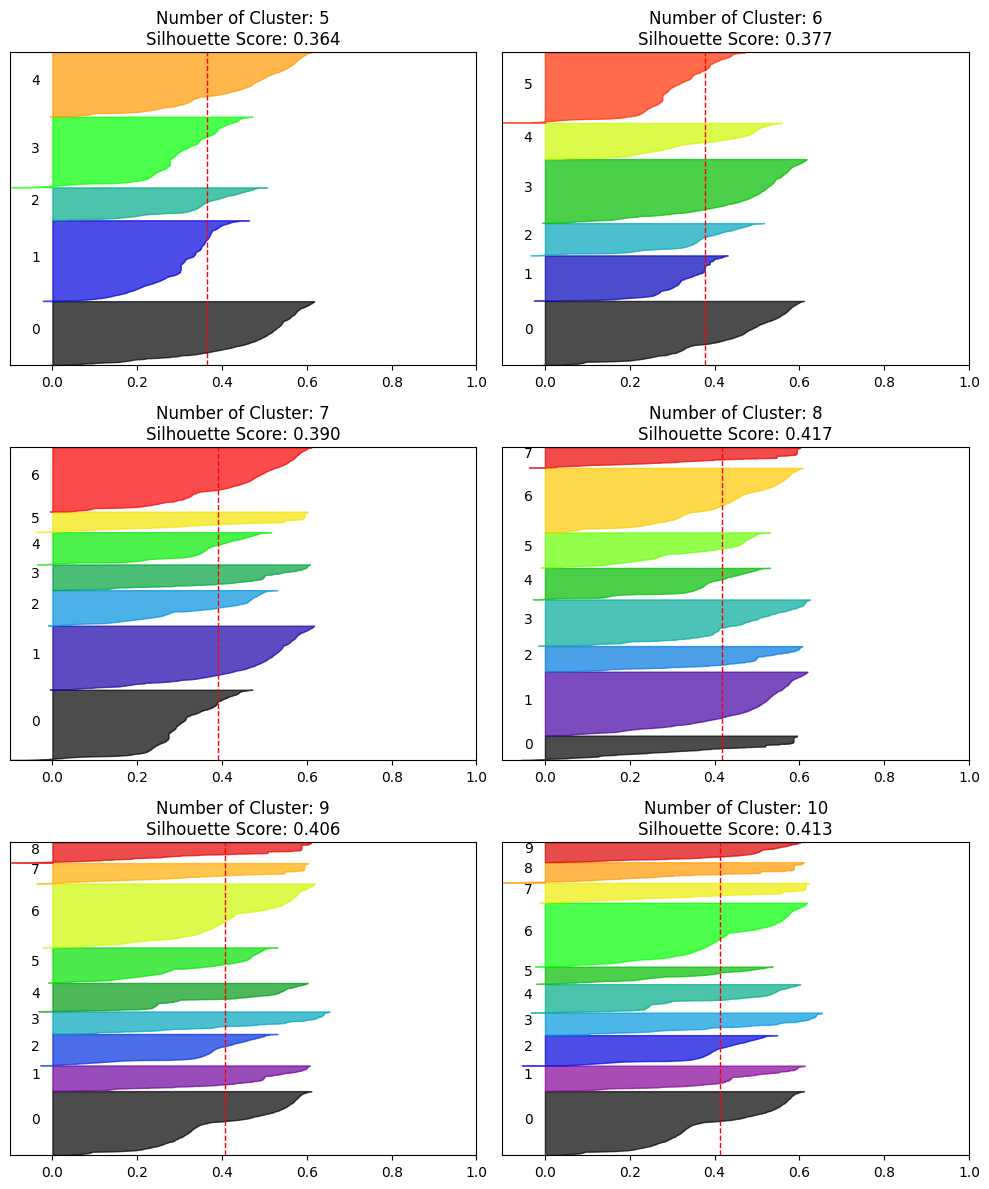

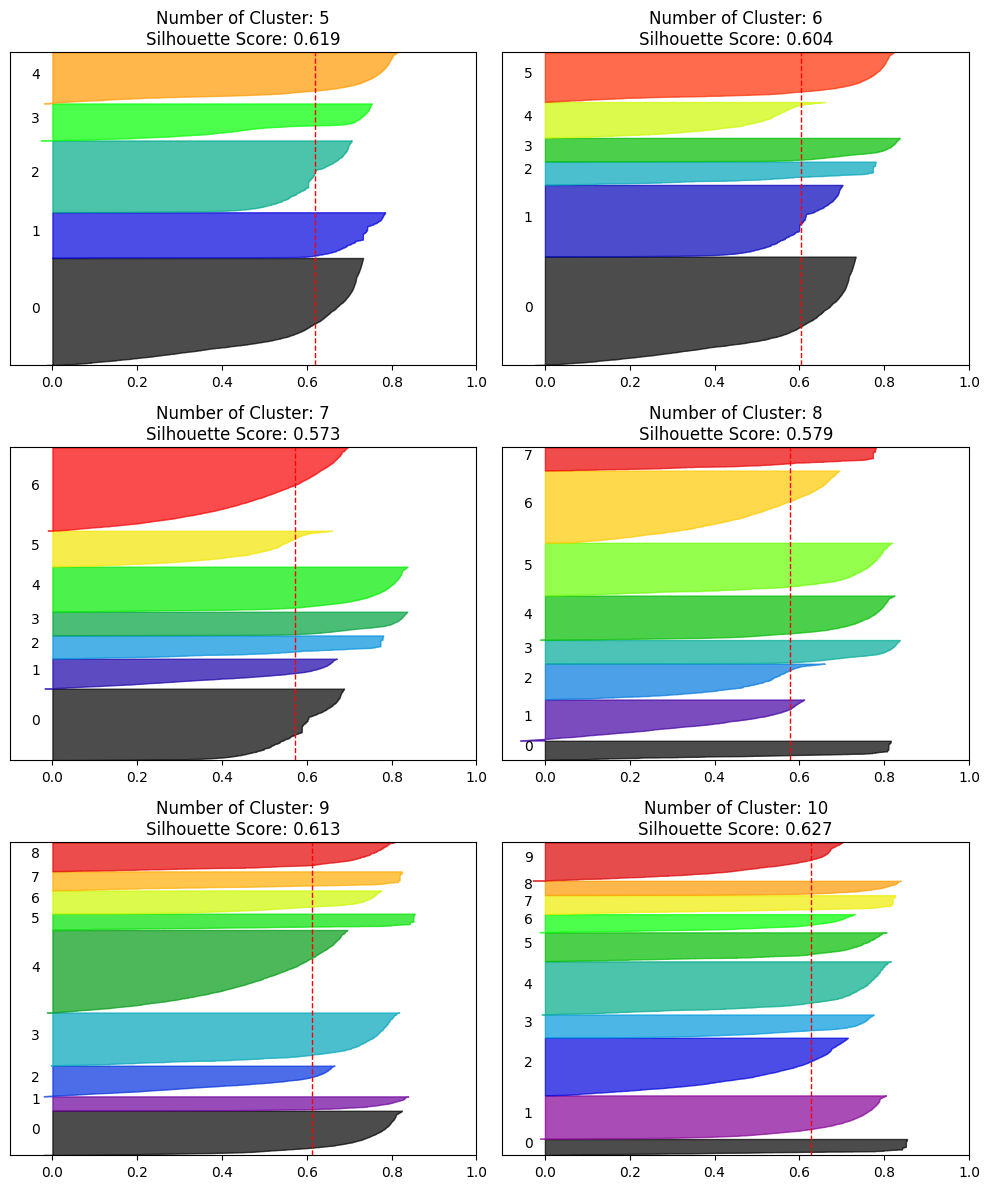

In [21]:
from sklearn.decomposition import PCA

# 원공간에서 비교
visualize_silhouette([5,6,7,8,9,10], scaled_df)

# PCA 2D로 축소해서 비교
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_df)
visualize_silhouette([5,6,7,8,9,10], X_pca)

***실루엣 스코어***
- 원공간에서는 실루엣 스코어가 0.36~0.42 수준 → 군집 간 경계가 애매하다
- PCA(2차원)에서는 0.57~0.63 수준으로 크게 향상 → 차원 축소 후 데이터 구조가 더 명확해짐.
- PCA 결과에서는 k=10이 가장 높은 스코어(0.627), 하지만 k=5~9도 큰 차이 없음.
- 하지만 군집 내에서 음수 구간이 있는 스코어가 있으므로 평균 실루엣 스코어도 0.624로 꽤 놓고 모든 군집에서 음수 비율이 적어 안정적인 6이 적합하다고 판단.

>> 스코어도 꽤 높고, 마이너스 값이 거의 없어 K=6로 결정

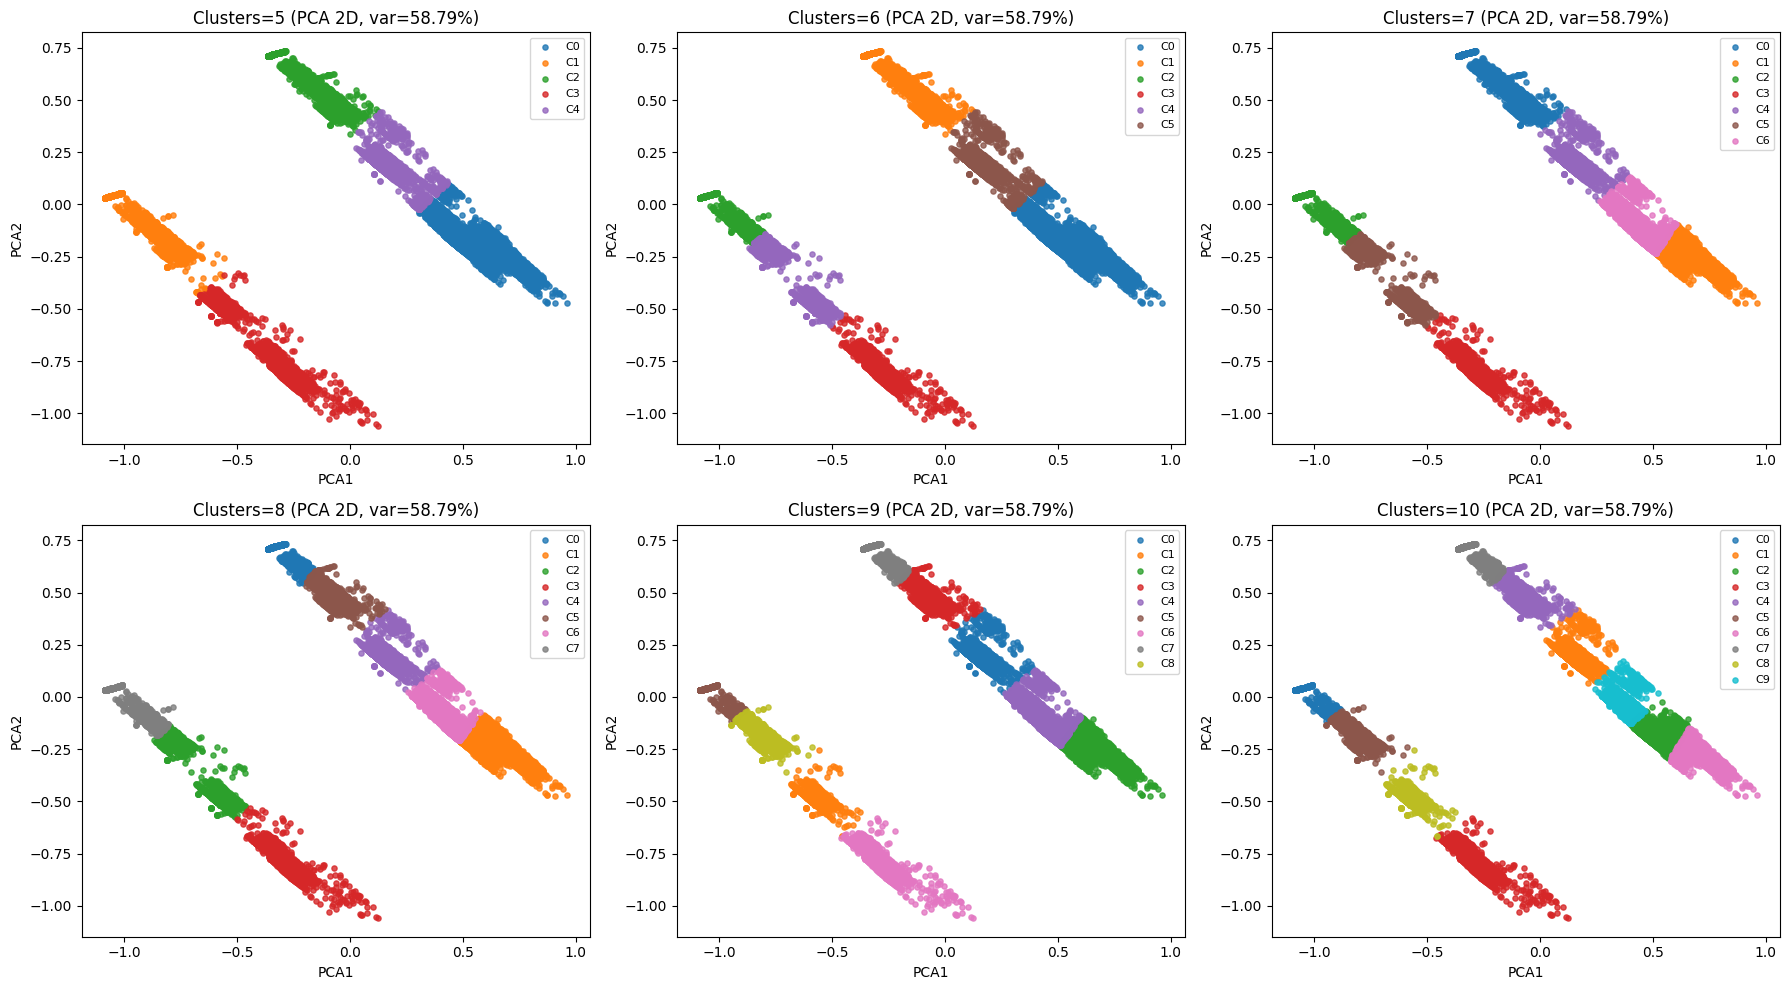

In [22]:
visualize_kmeans_plot_multi([5,6,7,8,9,10], scaled_df, ncols=3)

### 5. 군집화 실행(K-Means)

In [23]:
copy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14577 entries, 0 to 14576
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   appid                14577 non-null  int64  
 1   game_name            14577 non-null  object 
 2   genre                14577 non-null  object 
 3   price                14577 non-null  int64  
 4   release_date         14577 non-null  object 
 5   developer            14577 non-null  object 
 6   publisher            14575 non-null  object 
 7   user_reaction        14577 non-null  object 
 8   DLC여부                14577 non-null  float64
 9   all_reviews          14577 non-null  float64
 10  positive_reviews     14577 non-null  float64
 11  negative_reviews     14577 non-null  float64
 12  sns_channels         14577 non-null  int64  
 13  features             14577 non-null  object 
 14  bundle               14577 non-null  float64
 15  awards               14577 non-null 

In [24]:
# 유저 반응 점수 맵핑
REACTION_MAP = { "압도적으로 긍정적":0.98,"매우 긍정적":0.90,"긍정적":0.85,"대체로 긍정적":0.75,
    "복합적":0.50,"대체로 부정적":0.25,"부정적":0.15,"매우 부정적":0.10,"압도적으로 부정적":0.02, "없음":0}

copy_df["reaction_score"] = copy_df.get("user_reaction", pd.Series(np.nan, index=copy_df.index)).map(REACTION_MAP)

In [25]:
# 유저 활동량 열 생성
if {"peak_monthly_avg","avg_monthly_avg"} <= set(copy_df.columns):
    mm = MinMaxScaler()
    tmp = copy_df[["peak_monthly_avg","avg_monthly_avg"]].fillna(0)
    pn, an = mm.fit_transform(tmp).T
    copy_df["activity"] = (pn + an) / 2
else:
    copy_df["activity"] = np.nan

In [26]:
copy_df = copy_df.sort_values('appid').reset_index(drop=True)
scaled_df = scaled_df.loc[copy_df.index]  # scaled_df도 같은 순서로 맞춤

In [28]:
from sklearn.cluster import KMeans
from IPython.display import display

final_k = 6
features = [
    # 기본 성과 지표
    'price', 'all_reviews', 'positive_reviews', 'negative_reviews',
    'avg_monthly_avg',

    # 리뷰/평가 관련
    'review_count', 'positive_ratio', 'positive_score', 'reaction_score',

    # 성장/추세 관련 (_Avg 파생)
    'growth_rate', 'recent_3m_avg', 'early_3m_avg', 
    'std_player', 'trend_player',

    # 보조 지표
    'awards', 'sns_channels', 'discount'
]

# 1) KMeans 학습은 스케일된 피처 사용
kmeans = KMeans(n_clusters=final_k, random_state=42, n_init=10)
copy_df['cluster'] = kmeans.fit_predict(scaled_df)

# 2) 군집별 개수
print(copy_df['cluster'].value_counts().sort_index())

# 3) 원본 값으로 평균 계산 (스케일된 값 X)
cluster_summary_original = copy_df.groupby('cluster')[features].mean().round(3)

# 4) 보기 좋게 출력
display(cluster_summary_original)


cluster
0    3000
1    2120
2    1500
3    2988
4    1678
5    3291
Name: count, dtype: int64


,price,all_reviews,positive_reviews,negative_reviews,avg_monthly_avg,review_count,positive_ratio,positive_score,reaction_score,growth_rate,recent_3m_avg,early_3m_avg,std_player,trend_player,awards,sns_channels,discount
cluster,,,,,,,,,,,,,,,,,
0,7567.043,2791.729,2362.524,429.205,153.613,2791.729,0.695,2.796,0.438,79.151,174.387,120.585,98.476,55.207,0.095,0.727,34.105
1,8308.712,4157.837,3440.266,717.571,216.692,4157.837,0.690,2.973,0.458,62.294,178.372,174.957,203.448,-8.997,0.124,0.751,38.210
2,7588.880,6272.073,4925.567,1346.506,389.505,6272.073,0.700,2.948,0.459,80.995,427.662,293.366,167.874,128.776,0.089,0.735,34.947
3,8221.486,4518.967,3884.043,634.924,297.593,4518.967,0.695,2.972,0.462,26.253,291.526,341.412,99.165,-101.472,0.104,0.725,38.866
4,7913.075,1995.742,1662.403,333.339,66.275,1995.742,0.698,2.824,0.460,31.841,70.007,46.771,50.159,32.779,0.092,0.717,37.152
5,8612.820,3839.762,3136.527,703.235,173.835,3839.762,0.706,3.147,0.484,57.918,195.395,152.613,97.767,73.625,0.127,0.755,39.225


### 군집 분석

* 분석 기준(군집 규모 산정)

    1. 규모
        * 지표
            * all_reviews – 전체 리뷰 수 (누적 유저 기반의 간접 지표)
            * avg_monthly_avg – 평균 월별 동시 접속자 수 (최근 활성 유저 규모)
        * 산정 방법: 두 지표를 종합적으로 고려해 대형 / 중형 / 소형으로 분류
            * 대형: 리뷰 수 5,000 이상 & 동접 300명 이상
            * 중형: 리뷰 수 3,000 ~ 5,000 & 동접 150 ~ 300명
            * 소형: 리뷰 수 2,000 이하 또는 동접 150명 이하

    2. 성장률
        * 지표
            * growth_rate = (마지막 달 동접 – 첫 달 동접) ÷ 첫 달 동접 × 100
            * trend_player – 절대 변화량 (마지막 달 동접 – 첫 달 동접)
        * 산정 방법
            * _Avg 시계열 데이터에서 첫 달과 마지막 달의 변화 비율과 변화량을 측정하여 성장형 / 유지형 / 하락형 구분

    3. 유저 평가
        * 지표
            * positive_ratio – 긍정 리뷰 비율
            * positive_score – 긍정 평가 점수 (평균 평점 기반)
        * 산정 방법
            * 긍정 리뷰 비율과 점수를 함께 고려하여 낮음 / 평균 / 높음으로 평가 수준 구분
    
    4. 변동성
        * 지표
            * std_player – 월별 동시 접속자 수의 표준편차
        * 산정 방법
            * 표준편차 값이 높을수록 이벤트·업데이트 등으로 유저 수가 크게 변동하는 게임으로 해석하여 안정적 / 변동성 높음 두 단계로 구분

---

* Cluster 0 – 중소형·고성장형
    * 규모: 평균 리뷰 수(2,792)와 동접(153명) 모두 중간 이하
    * 성장률: 79.15로 높은 편 (동접이 과거 대비 크게 증가)
    * 유저 평가: 긍정 비율 0.695, 점수 2.796 (보통 수준)
    * 변동성: std 98.47 → 안정적인 성장
    >> 해석: 꾸준히 성장 중인 중소형 게임, 긍정 평가는 평균적이지만 시장 확대 가능성이 높음.

* Cluster 1 – 중형·안정 유지형
    * 규모: 리뷰 수 4,158, 동접 216명 (중간 규모)
    * 성장률: 62.29 (성장 있지만 과격하지 않음)
    * 유저 평가: 긍정 비율 0.690, 점수 2.973 (평균 이상)
    * 변동성: std 203.44 → 변동성 큼 (이벤트, 시즌제 영향 가능성)
    >> 해석: 규모는 안정적, 변동성 높은 중간급 타이틀. 특정 시기에 유저 몰림.

* Cluster 2 – 대형·고성장형
    * 규모: 리뷰 수 6,272, 동접 390명 (상위권)
    * 성장률: 80.99 (매우 높음)
    * 유저 평가: 긍정 비율 0.700, 점수 2.948 (평균 이상)
    * 변동성: std 167.87 → 중간 변동성
    >> 해석: 대규모 유저 기반 + 높은 성장률 → 신규 확장/마케팅 효과가 큰 성공 케이스.

* Cluster 3 – 대형·하락형
    * 규모: 리뷰 수 4,518, 동접 297명 (상위권)
    * 성장률: 26.25 (성장 둔화)
    * 유저 평가: 긍정 비율 0.695, 점수 2.972 (평균 이상)
    * 변동성: std 99.16 (안정적)
    * 트렌드: trend_player -101.47 → 최근 3개월 평균이 초반보다 크게 하락
    >> 해석: 한때 인기 있었지만 최근 하락세, 리텐션 전략 필요.

* Cluster 4 – 소형·저활동형
    * 규모: 리뷰 수 1,995, 동접 66명 (하위권)
    * 성장률: 31.84 (완만한 성장)
    * 유저 평가: 긍정 비율 0.698, 점수 2.824 (다소 낮음)
    * 변동성: std 50.15 (매우 안정적)
    >> 해석: 유저 기반이 작고 확장성이 제한적, 틈새시장 유지형.

* Cluster 5 – 중형·평가우수형
    * 규모: 리뷰 수 3,840, 동접 173명 (중간 규모)
    * 성장률: 57.92 (양호)
    * 유저 평가: 긍정 비율 0.706, 점수 3.147 (최고)
    * 변동성: std 97.76 (안정적)
    >> 해석: 유저 만족도가 매우 높음, 입소문/리뷰 마케팅에 최적화된 게임.

### 6. 군집별 대표 게임 뽑기

In [29]:
# 평균 접속자 수 기준
def top_games_avg_players(cluster_id, n=5):
    return (
        copy_df[copy_df['cluster'] == cluster_id]
        .sort_values('avg_monthly_avg', ascending=False)
        [['game_name', 'price', 'all_reviews', 'positive_ratio', 'positive_score', 
          'avg_monthly_avg', 'growth_rate', 'reaction_score']]
        .head(n)
    )

# 반응 점수 기준
def top_games_reaction(cluster_id, n=5):
    return (
        copy_df[copy_df['cluster'] == cluster_id]
        .sort_values('reaction_score', ascending=False)
        [['game_name', 'price', 'all_reviews', 'positive_ratio', 'positive_score', 
          'avg_monthly_avg', 'growth_rate', 'reaction_score']]
        .head(n)
    )

# 전체 리뷰 수 기준
def top_games_reviews(cluster_id, n=5):
    return (
        copy_df[copy_df['cluster'] == cluster_id]
        .sort_values('all_reviews', ascending=False)
        [['game_name', 'price', 'all_reviews', 'positive_ratio', 'positive_score', 
          'avg_monthly_avg', 'growth_rate', 'reaction_score']]
        .head(n)
    )

In [30]:
import pandas as pd

def get_top_games_all_clusters(df, clusters, sort_col, n=5):
    results = []
    for cid in clusters:
        top_games = (
            df[df['cluster'] == cid]
            .sort_values(sort_col, ascending=False)
            [['cluster', 'game_name', 'price', 'all_reviews',
              'positive_ratio', 'positive_score', 'avg_monthly_avg',
              'growth_rate', 'reaction_score']]
            .head(n)
        )
        results.append(top_games)
    return pd.concat(results, ignore_index=True)

# 클러스터 번호 목록 (0~5 자동 생성)
cluster_ids = sorted(copy_df['cluster'].unique())

# 1) 평균 접속자 수 기준
top_by_players = get_top_games_all_clusters(copy_df, cluster_ids, 'avg_monthly_avg', n=5)

# 2) 반응 점수 기준
top_by_reaction = get_top_games_all_clusters(copy_df, cluster_ids, 'reaction_score', n=5)

# 3) 리뷰 수 기준
top_by_reviews = get_top_games_all_clusters(copy_df, cluster_ids, 'all_reviews', n=5)

# 예시 출력
print("=== 평균 접속자 수 Top5 ===")
display(top_by_players)
print("\n=== 반응 점수 Top5 ===")
display(top_by_reaction)
print("\n=== 리뷰 수 Top5 ===")
display(top_by_reviews)

=== 평균 접속자 수 Top5 ===


,cluster,game_name,price,all_reviews,positive_ratio,positive_score,avg_monthly_avg,growth_rate,reaction_score
0,0,NARAKA: BLADEPOINT,0,329517.0,0.693297,8.808600,92263.558333,-0.330121,0.75
1,0,War Thunder,0,773543.0,0.642030,8.705120,58836.933333,-0.016294,0.00
2,0,HELLDIVERS™ 2,44800,0.0,0.000000,0.000000,52092.716667,37951.800000,0.25
3,0,7 Days to Die,47000,380049.0,0.873787,11.226470,30848.945833,0.302037,0.90
4,0,PAYDAY 2,11000,664328.0,0.896468,12.018532,21515.575000,-0.117912,0.90
5,1,Apex Legends™,0,1004461.0,0.672143,9.288985,131337.983333,-0.520535,0.00
6,1,Palworld,5020,390151.0,0.940941,12.113947,94048.083333,50987.300000,0.50
7,1,Monster Hunter: World,36800,498249.0,0.880479,11.550884,30932.270833,-0.172500,0.90
8,1,Crab Game,0,152365.0,0.914902,10.918474,29146.512500,-0.503647,0.90
9,1,ARK: Survival Evolved,16500,742797.0,0.835252,11.291092,26472.587500,-0.408278,0.90



=== 반응 점수 Top5 ===


,cluster,game_name,price,all_reviews,positive_ratio,positive_score,avg_monthly_avg,growth_rate,reaction_score
0,0,FlyKnight,6700,9171.0,0.965980,8.813513,41.066667,69.600000,0.98
1,0,Tomb Raider,2470,0.0,0.000000,0.000000,936.954167,0.274818,0.98
2,0,Iron Meat,21500,919.0,0.968444,6.609023,3.004167,4.400000,0.98
3,0,OpenTTD,0,14746.0,0.961956,9.233616,500.737500,0.008889,0.98
4,0,I wanna be the Creator,0,2859.0,0.953130,7.585562,34.233333,0.121519,0.98
5,1,Mosa Lina,8900,1694.0,0.953955,7.093074,16.633333,16.500000,0.98
6,1,Clone Drone in the Danger Zone,6150,33918.0,0.968542,10.103567,311.591667,0.181647,0.98
7,1,Keep Talking and Nobody Explodes,16500,15981.0,0.974032,9.427865,204.862500,0.473600,0.98
8,1,Mars First Logistics,5780,1325.0,0.964528,6.934883,24.729167,-0.112540,0.98
9,1,Pulling No Punches,0,607.0,0.962109,6.167285,0.000000,0.000000,0.98



=== 리뷰 수 Top5 ===


,cluster,game_name,price,all_reviews,positive_ratio,positive_score,avg_monthly_avg,growth_rate,reaction_score
0,0,Phasmophobia,21500,779687.0,0.957787,12.993959,16560.925000,-0.447593,0.98
1,0,War Thunder,0,773543.0,0.642030,8.705120,58836.933333,-0.016294,0.00
2,0,PAYDAY 2,11000,664328.0,0.896468,12.018532,21515.575000,-0.117912,0.90
3,0,Dying Light,27400,465959.0,0.951813,12.422930,5625.087500,0.370457,0.98
4,0,7 Days to Die,47000,380049.0,0.873787,11.226470,30848.945833,0.302037,0.90
5,1,Apex Legends™,0,1004461.0,0.672143,9.288985,131337.983333,-0.520535,0.00
6,1,ARK: Survival Evolved,16500,742797.0,0.835252,11.291092,26472.587500,-0.408278,0.90
7,1,Among Us,5500,706693.0,0.918511,12.370825,4547.870833,0.333840,0.90
8,1,Monster Hunter: World,36800,498249.0,0.880479,11.550884,30932.270833,-0.172500,0.90
9,1,Palworld,5020,390151.0,0.940941,12.113947,94048.083333,50987.300000,0.50


### 7. 각 군집에서 반복적으로 언급되는 게임 뽑아내기

* 여러 지표에서 반복적으로 상위권에 등장하는 게임을 우선순위로 선정
* 클러스터를 대표하는 핵심 게임이 뭔지 파악`

In [33]:
# 각 지표별 Top N appid 추출
def top_idx(col, c, n=10):
    return set(copy_df[copy_df['cluster'] == c]
               .sort_values(col, ascending=False)
               .head(n)['appid'])

cands = []
for c in sorted(copy_df['cluster'].unique()):
    counts = {}
    # 사용할 지표
    metrics = [
        'positive_ratio',    # 긍정 리뷰 비율
        'positive_score',    # 긍정 점수
        'avg_monthly_avg',   # 평균 동접
        'price',             # 가격
        'all_reviews',       # 전체 리뷰 수
        'reaction_score',    # 반응 점수
        'growth_rate'        # 성장률
    ]
    for col in metrics:
        for a in top_idx(col, c):
            counts[a] = counts.get(a, 0) + 1

    # 등장 횟수 상위 10개
    top_multi = sorted(counts.items(), key=lambda x: x[1], reverse=True)[:10]
    top_ids = [a for a, _ in top_multi]

    # 후보군 데이터프레임
    rows = copy_df[copy_df['appid'].isin(top_ids)][
        ['cluster', 'appid', 'game_name', 'positive_ratio', 'positive_score',
         'all_reviews', 'price', 'avg_monthly_avg', 'growth_rate', 'reaction_score']
    ].copy()
    rows['appear_times'] = rows['appid'].map(dict(top_multi))

    # 동일 appid 중복 제거 (등장횟수 > 긍정점수 순)
    rows = rows.sort_values(['appear_times', 'positive_score'], ascending=[False, False]) \
               .drop_duplicates(subset='appid')

    cands.append(rows)

# 최종 후보군 리스트 합치기
final_candidates = pd.concat(cands, ignore_index=True) \
    .sort_values(['appear_times', 'positive_score'], ascending=[False, False])

# 출력
display(
    final_candidates
      .style.format({
          'positive_ratio': '{:.3f}',
          'positive_score': '{:.3f}',
          'all_reviews': '{:,}',
          'price': '{:,.0f}',
          'avg_monthly_avg': '{:,.0f}',
          'growth_rate': '{:.2f}',
          'reaction_score': '{:.3f}'
      }).hide(axis='index')
)

cluster,appid,game_name,positive_ratio,positive_score,all_reviews,price,avg_monthly_avg,growth_rate,reaction_score,appear_times
0,739630,Phasmophobia,0.958,12.994,"779,687.0","21,500","16,561",-0.45,0.980,4
1,1623730,Palworld,0.941,12.114,"390,151.0","5,020","94,048",50987.30,0.500,4
4,8930,Sid Meier's Civilization® V,0.956,11.690,"205,588.0","8,000","14,584",-0.09,0.980,4
3,4000,Garry's Mod,0.968,13.528,"1,172,067.0","10,500","20,296",-0.11,0.980,3
3,1086940,Baldur's Gate 3,0.968,13.133,"774,783.0","66,000","102,156",-0.89,0.000,3
2,440,Team Fortress 2,0.902,12.603,"1,173,261.0",0,"65,012",-0.51,0.900,3
5,1174180,Red Dead Redemption 2,0.918,12.440,"764,886.0","73,000","31,683",0.36,0.900,3
1,548430,Deep Rock Galactic,0.972,12.411,"349,027.0","9,300","10,962",-0.48,0.900,3
3,892970,Valheim,0.943,12.379,"504,357.0","22,000","20,715",-0.06,0.900,3
2,108600,Project Zomboid,0.942,12.121,"388,956.0","21,500","24,657",-0.07,0.000,3


In [34]:
# CSV로 저장
output_path = "최종_군집화게임리스트.csv"
final_candidates.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"저장 완료: {output_path}")

저장 완료: 최종_군집화게임리스트.csv


In [36]:
# 오버워치 지표
ow_stats = copy_df[copy_df['game_name'].str.contains("Overwatch® 2", case=False, na=False)][features]
ow_cluster = copy_df[copy_df['game_name'].str.contains("Overwatch® 2", case=False, na=False)]['cluster'].iloc[0]

# 해당 군집 평균
cluster_avg = copy_df.groupby('cluster')[features].mean().round(3).loc[ow_cluster]

display(ow_stats)
display(cluster_avg)


,price,all_reviews,positive_reviews,negative_reviews,avg_monthly_avg,review_count,positive_ratio,positive_score,reaction_score,growth_rate,recent_3m_avg,early_3m_avg,std_player,trend_player,awards,sns_channels,discount
10997,0,349283.0,85360.0,263923.0,25894.145833,349283.0,0.244386,3.11926,0.25,-0.22597,23675.566667,21830.666667,5058.412405,-6401.1,0.0,1,0.0


price               8612.820
all_reviews         3839.762
positive_reviews    3136.527
negative_reviews     703.235
avg_monthly_avg      173.835
review_count        3839.762
positive_ratio         0.706
positive_score         3.147
reaction_score         0.484
growth_rate           57.918
recent_3m_avg        195.395
early_3m_avg         152.613
std_player            97.767
trend_player          73.625
awards                 0.127
sns_channels           0.755
discount              39.225
Name: 5, dtype: float64

### 오버워치2의 부정적 포인트

1. 평가/평판의 부진
    * 긍정 비율(positive_ratio)이 같은 군집 평균 대비 크게 낮음(0.24<0.70) → 유저 호감도가 낮음
    * 반응 점수(reaction_score)도 평균보다 낮아(0.25<0.49) 부정 여론이 강함
2. 성장세 하락
    * 성장률 -22 → 최근 유저 수가 감소세
    * trend_player -6.40 → 최근 3개월 동안 평균 접속자 수가 초반 대비 대폭 감소
3. 변동성 과다
    * std_player 5,058 → 이벤트/시즌에 따라 유저 수가 심하게 출렁
    * 안정적인 유저풀 유지 실패
4. 군집 포지션과 실제 규모 괴리
    * 절대 규모(동접·리뷰 수)는 압도적인 대형 게임이지만 패턴 유사성이 ‘중형·평가우수형’에 가까워져 브랜드 포지션 저하 위험

>> '오버워치 2'는 군집 5에 들어갈 만큼 압도적인 규모를 보유하고 있으나 최근 유저 평판과 성장세 지표에서 뚜렷한 부진을 보인다.
<br> 긍정 비율과 반응 점수는 동종군집 대비 현저히 낮으며, 성장률은 하락세가 지속되고 있다.
<br> 또한 변동성이 매우 높아 안정적인 유저풀 확보에 실패하고 있으며 이로 인해
<br>실제 규모와는 달리 군집상 '중형/평가우수형 패턴'으로 분류되어도 괜찮을것 같다는 판단이 선다.

### 마케팅 인사이트

한번에 바꾸는 것이 아닌 단기-중기-장기 로 나눠서 서서히 유저를 정착화

1. 유저 호감도 회복 필요
- 문제 : 긍정 비율과 반응 점수가 군집 평균의 절반 이하
- 원인 추정 : 최근 운영 이슈·매칭/밸런스 불만·콘텐츠 부족
- 전략 방향
    * 단기: 기존 유저 대상 평판 회복 캠페인 (핵심 불만 요소 해결 업데이트 → 적극 알리기)
    * 중기: 긍정 경험 유도형 이벤트
    * 장기: 커뮤니티 관리 강화(피드백 반영 주기 단축)

2. 이탈 방지 & 복귀 유도
- 문제: 성장률 -22, trend_player -6,401 → 유저 감소세
- 원인 추정: 신규 콘텐츠 주기 불규칙, 메타 고착화, 경쟁작 유입
- 전략 방향
    * 단기: 복귀 보너스 패스, 시즌 시작 시 신규 모드/맵 배치
    * 중기: IP 협업 콘텐츠(다른 블리자드 게임·외부 IP 콜라보)로 관심도 회복
    * 장기: 신규 유저-기존 유저 매칭 개선, 진입장벽 완화 방법 강구

3. 유저풀 안정화
- 문제: std_player 5,058 → 이벤트 종료 후 급감하는 불안정한 유저풀
- 원인 추정: 단발성 이벤트 중심 운영, 핵심 콘텐츠 지속성 부족
- 전략 방향
    * 단기: 월 단위 지속 이벤트(소규모 챌린지·시즌 미션)
    * 중기: e스포츠/커뮤니티 리그 재활성화로 고정 유저층 강화(하이라이트 중심의 숏폼 및 밈화)
    * 장기: 장르 내 새로운 플레이 루프 도입(장기 과제·진행형 스토리) 

4. 브랜드 포지션 회복
- 문제: 규모는 대형 게임이지만 군집 패턴상 중형·평가우수형 → 리더십 이미지 약화
- 원인 추정: 시장 내 차별성 감소, 주요 강점(팀 기반 FPS)의 약화
- 전략 방향
    * 단기: 경쟁작 대비 차별 포인트(영웅·팀 플레이 시너지) 집중 홍보
    * 중기: 신규 유저 확보 캠페인과 e스포츠/팬덤 재결집 이벤트 병행
    * 장기: 글로벌 게이밍 이벤트(지스타 등)에서 대형 부스 운영으로 리더십 강조